# Validate ResNet-101
- ResNet-101 모델 및 pre-trained model 로드

### Sample Image Showing

In [1]:
#some basic imports and setups
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

#mean of imagenet dataset in BGR
imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)

current_dir = os.getcwd()
image_dir = os.path.join(current_dir, 'images')

- images 폴더의 모든 image 파일 가져오기 및 출력

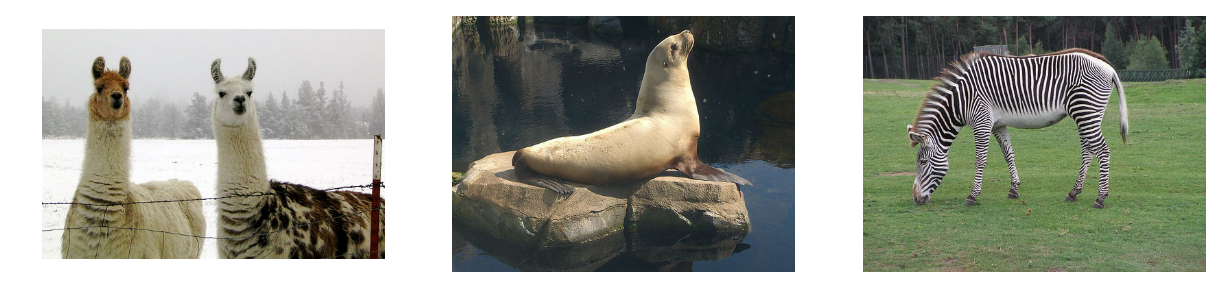

In [2]:
#get list of all images
img_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpeg')]

#load all images
imgs = []
for f in img_files:
    imgs.append(cv2.imread(f))
    
#plot images
fig = plt.figure(figsize=(15,6))
for i, img in enumerate(imgs):
    fig.add_subplot(1,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

- ResNet-101 model load
- layer fc_final을 score로 가져오기 및 최종 softmax layer로 전달
- input dim : [-1, 224, 224, 3]

In [3]:
import sys
sys.path.append('./Network')
sys.path.append('./classes')
from resnet101 import ResNet101
from caffe_classes import class_names

#placeholder for input and dropout rate
x = tf.placeholder(tf.float32, [1, 224, 224, 3])
keep_prob = tf.placeholder(tf.float32)

#create model with default config ( == no skip_layer and 1000 units in the last layer)
model = ResNet101(x, keep_prob, 1000, [], './Network/pretrained_model/resnet-101.npy', name='ResNet-101')

#define activation of last layer as score
score = model.fc_final

#create op to calculate softmax 
softmax = tf.nn.softmax(score)

Start to load pre-trained model : 
Load Model: |██████████████████████████████████████████████████| 100.0% Complete


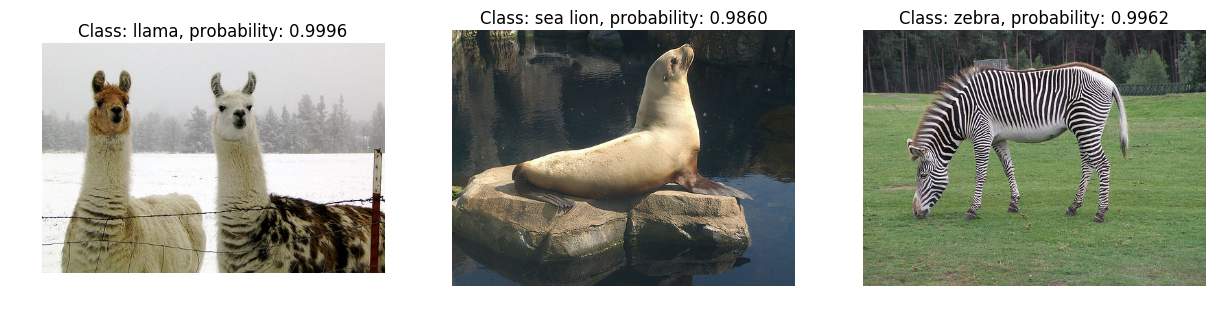

In [4]:
writer = tf.summary.FileWriter('./summary/resnet-101')
with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Load the pretrained weights into the model
    model.load_initial_weights(sess)
    
    # Create figure handle
    fig2 = plt.figure(figsize=(15,6))
    
    # Summary write
    writer.add_graph(sess.graph)
    
    # Loop over all images
    for i, image in enumerate(imgs):
        
        # Convert image to float32 and resize to (227x227)
        img = cv2.resize(image.astype(np.float32), (224,224))
        
        # Subtract the ImageNet mean
        img -= imagenet_mean
        
        # Reshape as needed to feed into model
        img = img.reshape((1,224,224,3))
        
        # Run the session and calculate the class probability
        probs = sess.run(softmax, feed_dict={x: img, keep_prob: 1})
        
        # Get the class name of the class with the highest probability
        class_name = class_names[np.argmax(probs)]
        
        # Plot image with class name and prob in the title
        fig2.add_subplot(1,3,i+1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Class: " + class_name + ", probability: %.4f" %probs[0,np.argmax(probs)])
        plt.axis('off')

## Reference
- reference: https://github.com/ethereon/caffe-tensorflow
- reference: https://github.com/kratzert/finetune_alexnet_with_tensorflow